In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xskillscore as xs
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *
from src.score import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
#limit_mem()

In [4]:
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions_'
result_dir='/home/garg/data/WeatherBench/tmp'
# # model_save_dir='/home/rasp/data/myWeatherBench/predictions_P/saved_models/'
# # datadir='/data/stephan/WeatherBench/5.625deg/'
# # pred_save_dir='/home/rasp/data/myWeatherBench/predictions_P/'

In [5]:
!ls {result_dir}

categorical_crps.nc	      dropout_mae.nc	      parametric_spreadskill.nc
categorical_quantile_rmse.nc  dropout_ranks.pkl       preds_cat_ens.nc
categorical_ranks.pkl	      dropout_rmse.nc	      preds_param_ztt_ens.nc
categorical_rmse.nc	      dropout_spreadskill.nc  tigge_crps.nc
categorical_spreadskill.nc    figures		      tigge_ranks.pkl
dropout_crps.nc		      parametric_crps.nc      tigge_rmse.nc
dropout_det_mae.nc	      parametric_ranks.pkl    tigge_spreadskill.nc
dropout_det_rmse.nc	      parametric_rmse.nc


# Data

In [6]:
!ls {datadir}

2017_2018_subset.zip	  geopotential	     toa_incident_solar_radiation
2m_temperature		  geopotential_500   u_component_of_wind
6hr_precipitation	  specific_humidity  v_component_of_wind
backup_specific_humidity  temperature
constants		  temperature_850


In [7]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
t2m_valid = xr.open_mfdataset(f'{datadir}/2m_temperature/*.nc',combine='by_coords')
tp_valid=xr.open_mfdataset(f'{datadir}/6hr_precipitation/*.nc',combine='by_coords')

# SR: Not necessary because we never look at other levels
ztt_valid=xr.merge([z500_valid,t850_valid, t2m_valid])  #.rename({'z':'z_500', 't':'t_850'})
valid=xr.merge([ztt_valid, tp_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

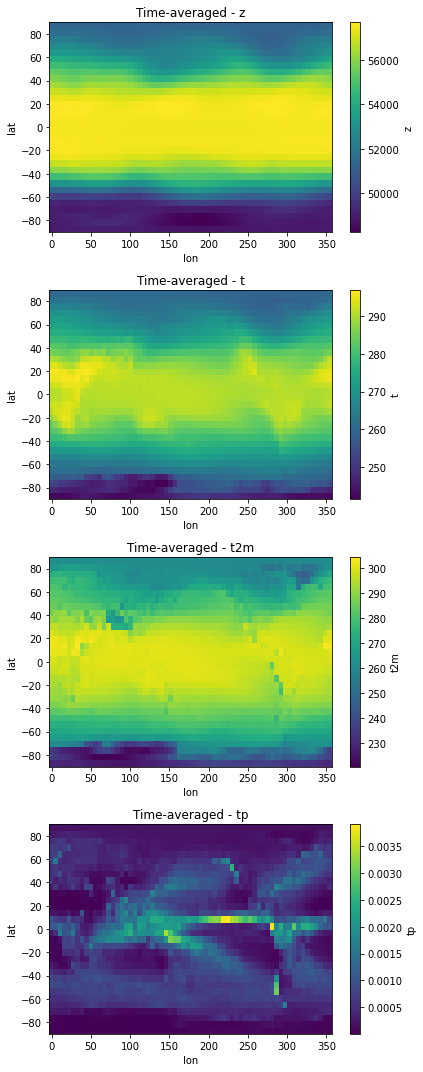

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    valid[v].mean('time').plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged - {v}')
fig.tight_layout()


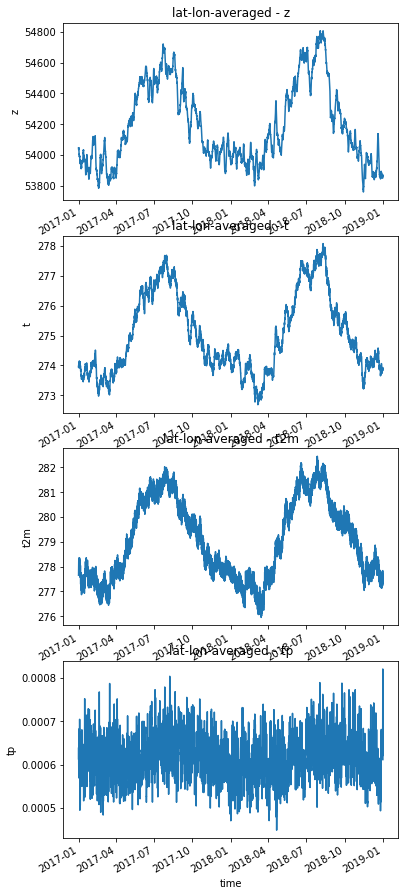

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    valid[v].mean({'lat','lon'}).plot(ax=axs[j])
    axs[j].set_title(f'lat-lon-averaged - {v}')

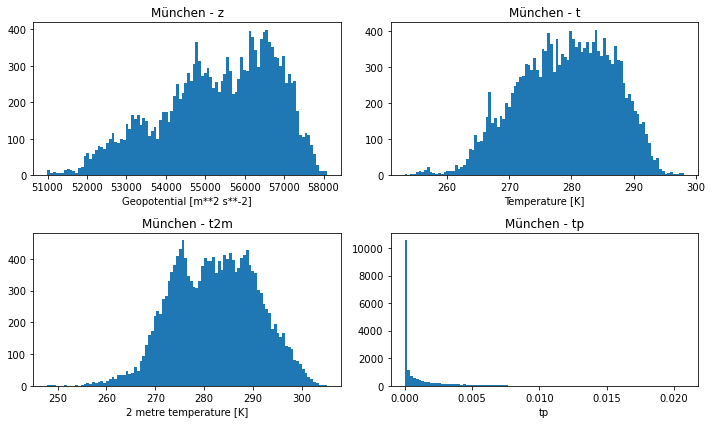

In [27]:
#München: 48.1351, 11.5820
# fig, axs = plt.subplots(4, 1, figsize=(6, 15))
# for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
#     valid[v].sel(lat=48.1351, lon=11.5820, method='nearest').plot.hist(ax=axs[j], bins=100)
#     axs[j].set_title(f'München - {v}')
# #    plt.savefig(f'{result_dir}/figures/munich_valid_{v}.pdf')
# fig.tight_layout()

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    valid[v].sel(lat=48.1351, lon=11.5820, method='nearest').plot.hist(ax=axs[j//2][j%2], bins=100)
    axs[j//2][j%2].set_title(f'München - {v}')
#    plt.savefig(f'{result_dir}/figures/munich_valid_{v}.pdf')
fig.tight_layout()
plt.savefig(f'{result_dir}/figures/munich_datamap.pdf')


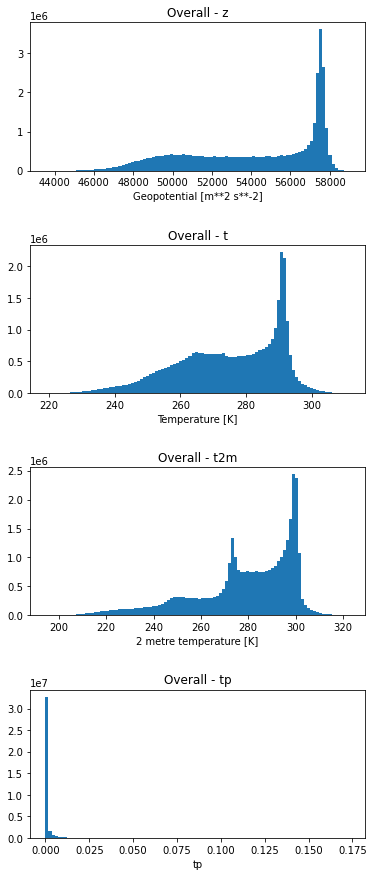

In [11]:
#Flattened
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
fig.subplots_adjust(hspace=0.5)
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    valid[v].plot.hist(ax=axs[j], bins=100)
    axs[j].set_title(f'Overall - {v}')

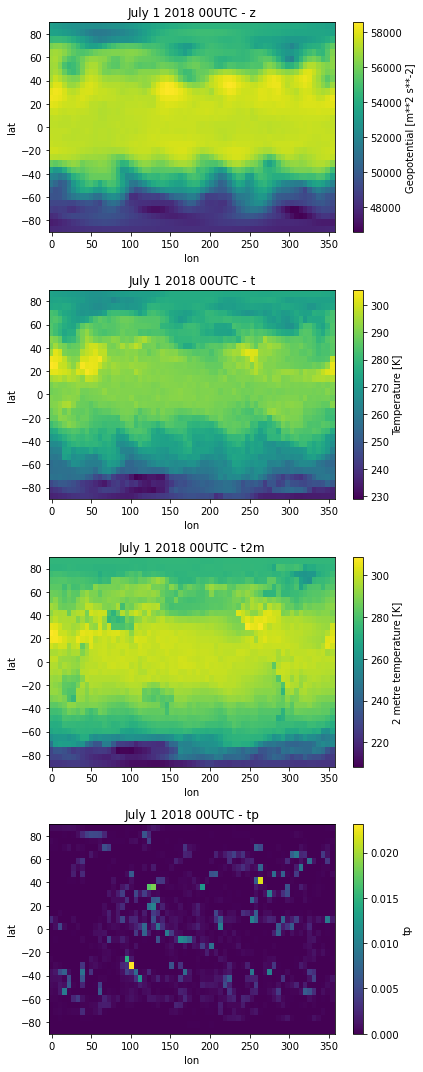

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    valid[v].sel(time='2018-07-01T00').plot(ax=axs[j])
    axs[j].set_title(f'July 1 2018 00UTC - {v}')
    plt.savefig(f'{result_dir}/figures/july_1_valid_{v}.pdf')
fig.tight_layout()

# Predictions

/home/garg/miniconda3/envs/weatherbench/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  This is separate from the ipykernel package so we can avoid doing imports until
/home/garg/miniconda3/envs/weatherbench/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/h

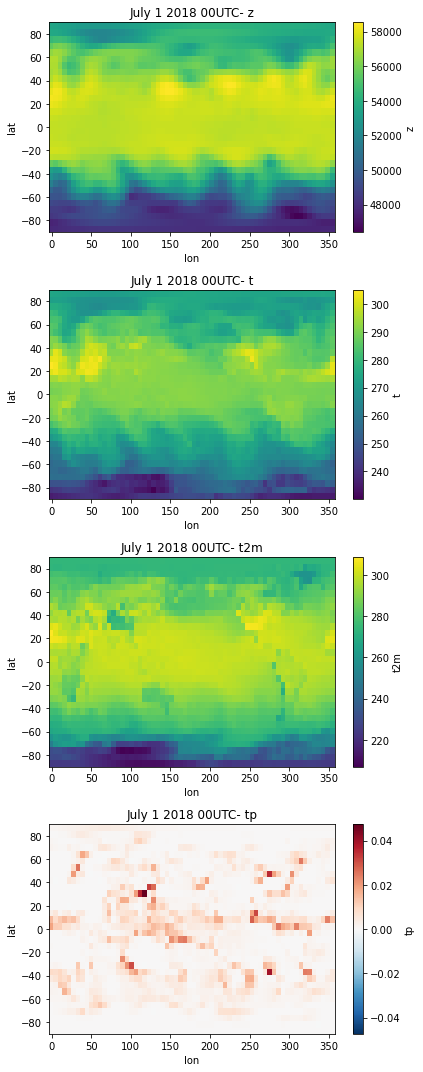

In [10]:
#tigge
tigge_dir='/home/garg/data/WeatherBench/tigge/5.625deg'
tigge_z = xr.open_mfdataset(f'{tigge_dir}/geopotential_500_ens/*nc')
tigge_t = xr.open_mfdataset(f'{tigge_dir}/temperature_850_ens/*nc')
tigge_t2m = xr.open_mfdataset(f'{tigge_dir}/2m_temperature/*nc')
tigge_tp = xr.open_mfdataset(f'{tigge_dir}/total_precipitation/*nc')

tigge_z *= 9.806
tigge_tp = tigge_tp.diff('step') / 1000.
tigge = xr.merge([tigge_z, tigge_t, tigge_t2m, tigge_tp], compat="override")
tigge = tigge.rename({'number': 'member', 'gh':'z'})
tigge = tigge.sel(step='3 days')
tigge['time'] = tigge['valid_time']
tigge = tigge.sel(time=slice('2017', '2018'))
tigge.load()


fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    tigge[v].sel(time='2018-07-01T00').mean('member').plot(ax=axs[j])
    axs[j].set_title(f'July 1 2018 00UTC- {v}')
    plt.savefig(f'{result_dir}/figures/july_1_tigge_{v}.pdf')
fig.tight_layout()

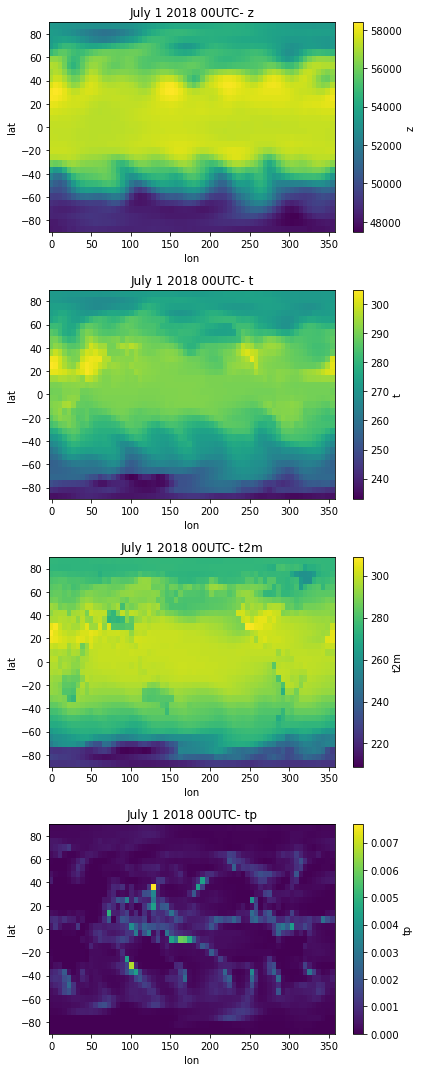

In [11]:
#DR 0.1 
pred_save_dir_dr='/home/garg/data/WeatherBench/predictions_'
mc_exp_ids_ztt ='C/017-resnet_d3_ztt_3d'
mc_exp_ids_tp = 'C/054-resnet_d3_tp_3d'
members=50
preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt+f'_m{members}.nc')
preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp+f'_m{members}.nc')
preds = xr.merge([preds_ztt, preds_tp])

fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    preds[v].sel(time='2018-07-01T00').mean('member').plot(ax=axs[j])
    axs[j].set_title(f'July 1 2018 00UTC- {v}')
    plt.savefig(f'{result_dir}/figures/july_1_mc_{v}.pdf')
fig.tight_layout()

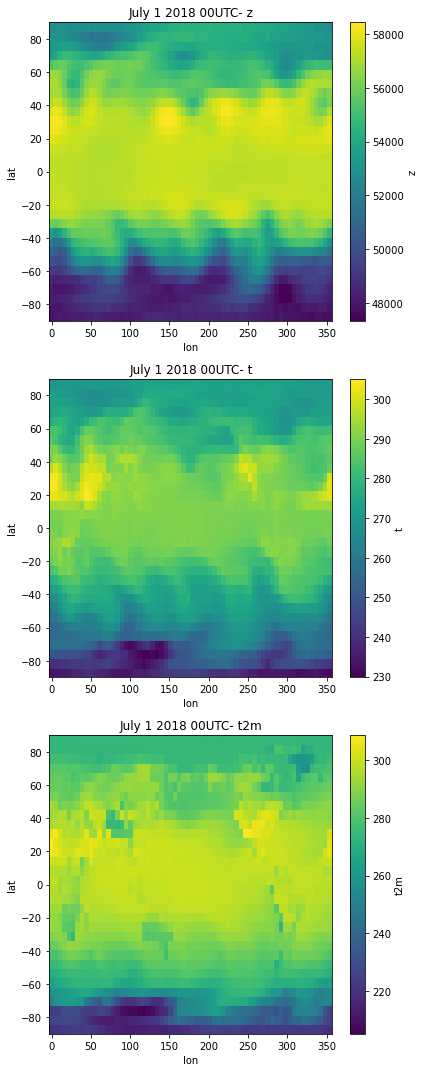

In [12]:
#Parametric
preds_ztt = xr.open_dataset(f'{result_dir}/preds_param_ztt_ens.nc')
fig, axs = plt.subplots(3, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m']):
    
    preds_ztt[v].sel(time='2018-07-01T00').mean('member').plot(ax=axs[j])
    axs[j].set_title(f'July 1 2018 00UTC- {v}')
    plt.savefig(f'{result_dir}/figures/july_1_param_{v}.pdf')
fig.tight_layout()

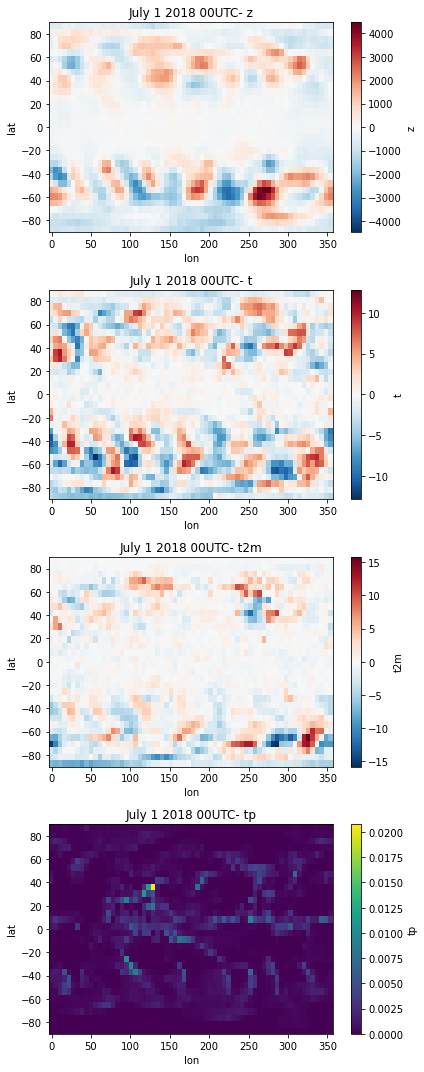

In [13]:
#Categorical (Difference of Input)
cat = xr.open_dataset(f'{result_dir}/preds_cat_ens.nc')
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    cat[v].sel(time='2018-07-01T00').mean('member').plot(ax=axs[j])
    axs[j].set_title(f'July 1 2018 00UTC- {v}')
    plt.savefig(f'{result_dir}/figures/july_1_cat_{v}.pdf')
    
fig.tight_layout()

# Scores

## Dropout

In [55]:
dropout_det_rmse=xr.open_dataset(f'{result_dir}/dropout_det_rmse.nc')
dropout_mc_rmse=xr.open_dataset(f'{result_dir}/dropout_rmse.nc')

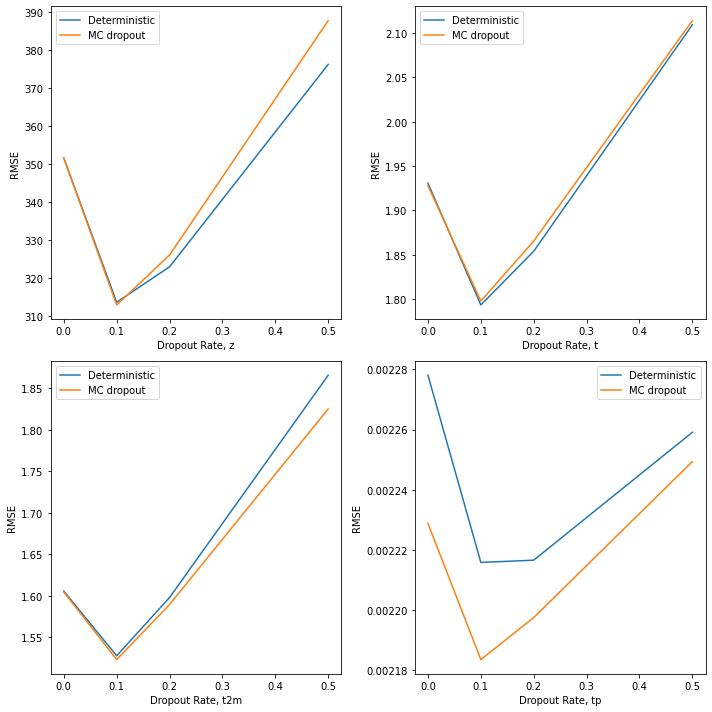

In [56]:
fig, ax = plt.subplots(2, 2, figsize=(10 , 10))
x=[0.0, 0.1, 0.2, 0.5]
for j, v in enumerate(['z','t','t2m','tp']):
    
    ax[j//2][j%2].plot(x, dropout_det_rmse[v], label='Deterministic')
    ax[j//2][j%2].plot(x, dropout_mc_rmse[v], label='MC dropout')
    ax[j//2][j%2].set_xlabel(f'Dropout Rate, {v}')
    ax[j//2][j%2].set_ylabel('RMSE')
#ax.set_title("Simple Plot")
    ax[j//2][j%2].legend()
    fig.tight_layout()
plt.savefig(f'{result_dir}/figures/det_dr_rmse.pdf')
#plt.savefig(f'{result_dir}/figures/det_dr_rmse.eps', format='eps')

In [57]:
dropout_det_mae=xr.open_dataset(f'{result_dir}/dropout_det_mae.nc')
dropout_mc_mae=xr.open_dataset(f'{result_dir}/dropout_mae.nc')
dropout_mc_crps=xr.open_dataset(f'{result_dir}/dropout_crps.nc')

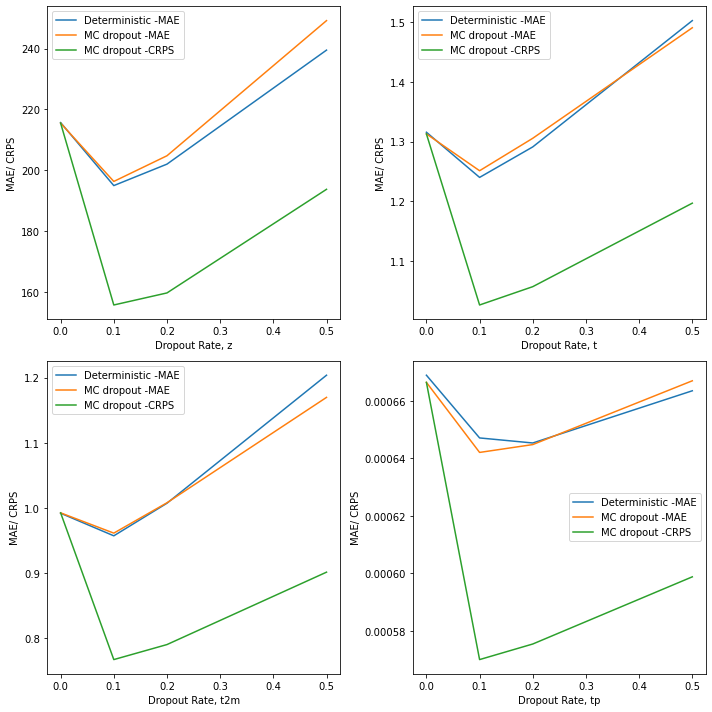

In [11]:


fig, ax = plt.subplots(2, 2, figsize=(10 , 10))
x=[0.0, 0.1, 0.2, 0.5]
for j, v in enumerate(['z','t','t2m','tp']):
    ax[j//2][j%2].plot(x, dropout_det_mae[v], label='Deterministic -MAE')
    ax[j//2][j%2].plot(x, dropout_mc_mae[v], label='MC dropout -MAE')
    ax[j//2][j%2].plot(x, dropout_mc_crps[v], label='MC dropout -CRPS')
    ax[j//2][j%2].set_xlabel(f'Dropout Rate, {v}')
    ax[j//2][j%2].set_ylabel('MAE/ CRPS')
#ax.set_title("Simple Plot")
    ax[j//2][j%2].legend()
    fig.tight_layout()
plt.savefig(f'{result_dir}/figures/det_dr_crps.pdf')



In [92]:
#Why is deterministic forecast better performing (both RMSE, CRPS) than MC. Is it the same network?

In [58]:
dropout_mc_ss=xr.open_dataset(f'{result_dir}/dropout_spreadskill.nc')

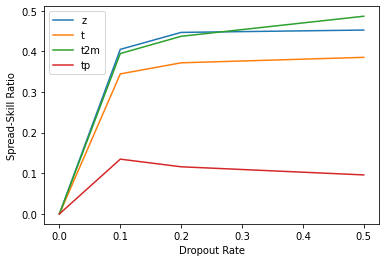

In [127]:
fig, ax = plt.subplots()
x=[0.0, 0.1, 0.2, 0.5]
for v in ['z','t','t2m','tp']:
    ax.plot(x, dropout_mc_ss[v], label=f'{v}')
    ax.set(xlabel='Dropout Rate', ylabel='Spread-Skill Ratio')
    #ax.set(title='Comparing Spread-Skill Ratio for Different Dropout Rates')
    ax.legend()
plt.savefig(f'{result_dir}/figures/dr_ss.pdf')



In [62]:
dropout_det_mae

<xarray.Dataset>
Dimensions:     (concat_dim: 4)
Coordinates:
  * concat_dim  (concat_dim) float64 0.0 0.1 0.2 0.5
Data variables:
    t2m         (concat_dim) float64 ...
    z           (concat_dim) float64 ...
    t           (concat_dim) float64 ...
    tp          (concat_dim) float64 ...

In [ ]:
#Considering dr=0.1 from now on, since best among all MC.

In [13]:
dropout_mc_rmse=dropout_mc_rmse.sel(concat_dim=0.1)
dropout_mc_ss=dropout_mc_ss.sel(concat_dim=0.1)
dropout_mc_crps=dropout_mc_crps.sel(concat_dim=0.1)
dropout_mc_mae=dropout_mc_mae.sel(concat_dim=0.1)

In [14]:
dropout_det_rmse=dropout_det_rmse.sel(concat_dim=0.1)
#dropout_det_ss=dropout_det_ss.sel(concat_dim=0.1)
#dropout_det_crps=dropout_det_crps.sel(concat_dim=0.1)
dropout_det_mae=dropout_det_mae.sel(concat_dim=0.1)

In [22]:
#dropout_mc_rmse, dropout_mc_ss, dropout_mc_crps

## RMSEs

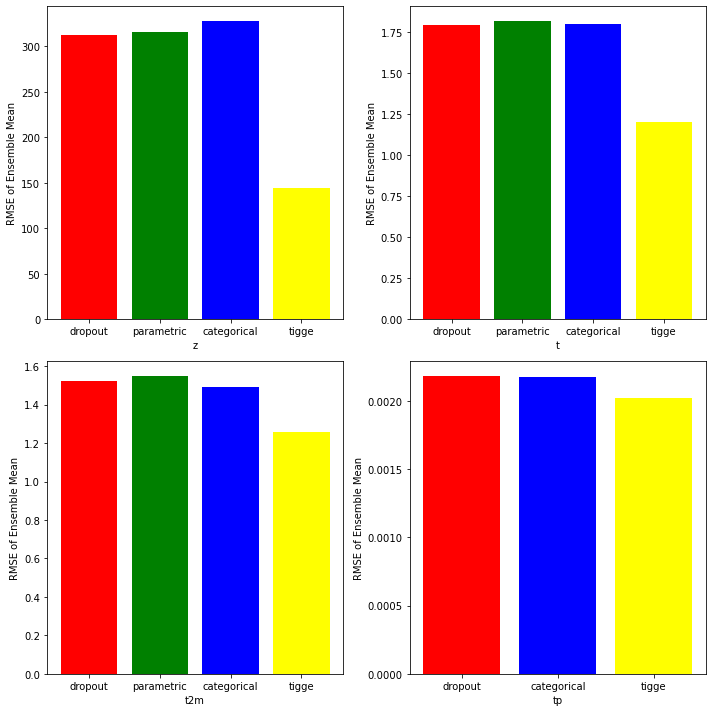

In [24]:

labels = ['dropout','parametric','categorical','tigge']
x = np.arange(len(labels))  # the label locations

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    rmses=[]
    
    if (v=='tp'):
        labels = ['dropout','categorical','tigge']
        for var in ['dropout','categorical', 'tigge']:
            rmse=xr.open_dataset(f'{result_dir}/{var}_rmse.nc')
            rmse=rmse[v]
            if (var=='dropout'):
                rmse=rmse.sel(concat_dim=0.1)
            rmses.append(rmse)
        axs[j//2][j%2].bar(labels, rmses, color=('red','blue','yellow'), width = 0.8) 
  
        axs[j//2][j%2].set_xlabel(f'{v}') 
        axs[j//2][j%2].set_ylabel("RMSE of Ensemble Mean")     
        
            
    else:
        labels = ['dropout','parametric','categorical','tigge']
        for var in ['dropout','parametric','categorical','tigge']:
            rmse=xr.open_dataset(f'{result_dir}/{var}_rmse.nc')
            rmse=rmse[v]
            if (var=='dropout'):
                rmse=rmse.sel(concat_dim=0.1)
            rmses.append(rmse)
        
        axs[j//2][j%2].bar(labels, rmses, color=('red','green','blue','yellow'), width = 0.8) 
  
        axs[j//2][j%2].set_xlabel(f'{v}') 
        axs[j//2][j%2].set_ylabel("RMSE of Ensemble Mean") 
    
    
    # creating the bar plot 
    
    fig.tight_layout()
plt.savefig(f'{result_dir}/figures/rmse.pdf')

## Spreadskill

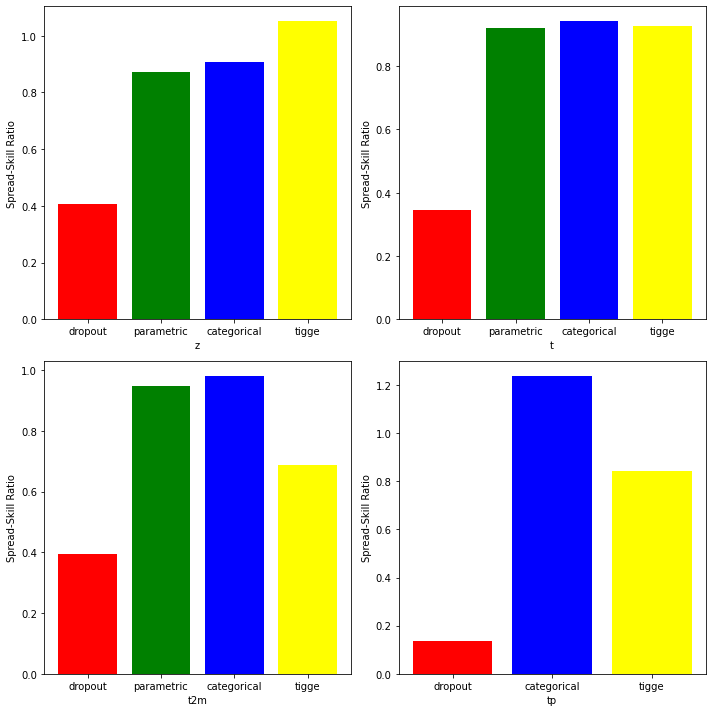

In [37]:

labels = ['dropout','parametric','categorical','tigge']
x = np.arange(len(labels))  # the label locations

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    sss=[]
    
    if (v=='tp'):
        labels = ['dropout','categorical','tigge']
        for var in ['dropout','categorical', 'tigge']:
            ss=xr.open_dataset(f'{result_dir}/{var}_spreadskill.nc')
            ss=ss[v]
            if (var=='dropout'):
                ss=ss.sel(concat_dim=0.1)
            sss.append(ss)
        axs[j//2][j%2].bar(labels, sss, color=('red','blue','yellow'), width = 0.8) 
  
        axs[j//2][j%2].set_xlabel(f'{v}') 
        axs[j//2][j%2].set_ylabel("Spread-Skill Ratio")     
        
            
    else:
        labels = ['dropout','parametric','categorical','tigge']
        for var in ['dropout','parametric','categorical','tigge']:
            ss=xr.open_dataset(f'{result_dir}/{var}_spreadskill.nc')
            ss=ss[v]
            if (var=='dropout'):
                ss=ss.sel(concat_dim=0.1)
            sss.append(ss)
        
        axs[j//2][j%2].bar(labels, sss, color=('red','green','blue','yellow'), width = 0.8) 
  
        axs[j//2][j%2].set_xlabel(f'{v}') 
        axs[j//2][j%2].set_ylabel("Spread-Skill Ratio") 
    
    
    # creating the bar plot 
    
    fig.tight_layout()
plt.savefig(f'{result_dir}/figures/spreadskill.pdf')

## CRPS

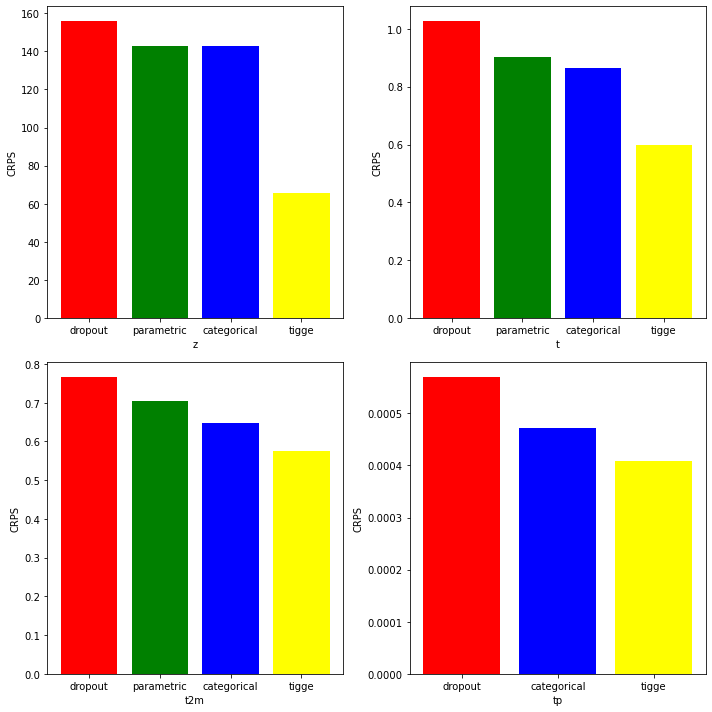

In [46]:

labels = ['dropout','parametric','categorical','tigge']
x = np.arange(len(labels))  # the label locations

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    crpss=[]
    
    if (v=='tp'):
        labels = ['dropout','categorical', 'tigge']
        for var in ['dropout','categorical', 'tigge']:
            crps=xr.open_dataset(f'{result_dir}/{var}_crps.nc')
            crps=crps[v]
            if (var=='dropout'):
                crps=crps.sel(concat_dim=0.1)
            crpss.append(crps)
        axs[j//2][j%2].bar(labels, crpss, color=('red','blue','yellow'), width = 0.8) 
  
        axs[j//2][j%2].set_xlabel(f'{v}') 
        axs[j//2][j%2].set_ylabel("CRPS")     
        
            
    else:
        labels = ['dropout','parametric','categorical','tigge']
        for var in ['dropout','parametric','categorical','tigge']:
            crps=xr.open_dataset(f'{result_dir}/{var}_crps.nc')
            crps=crps[v]
            if (var=='dropout'):
                crps=crps.sel(concat_dim=0.1)
            crpss.append(crps)
        
        axs[j//2][j%2].bar(labels, crpss, color=('red','green','blue','yellow'), width = 0.8) 
  
        axs[j//2][j%2].set_xlabel(f'{v}') 
        axs[j//2][j%2].set_ylabel("CRPS") 
    
    
    # creating the bar plot 
    
    fig.tight_layout()
plt.savefig(f'{result_dir}/figures/crps.pdf')



## Rank Histograms -Set equal y coordinate

In [133]:
with open(f'/home/garg/data/WeatherBench/tmp/dropout_ranks.pkl', 'rb') as f:
    ranks= pickle.load(f)

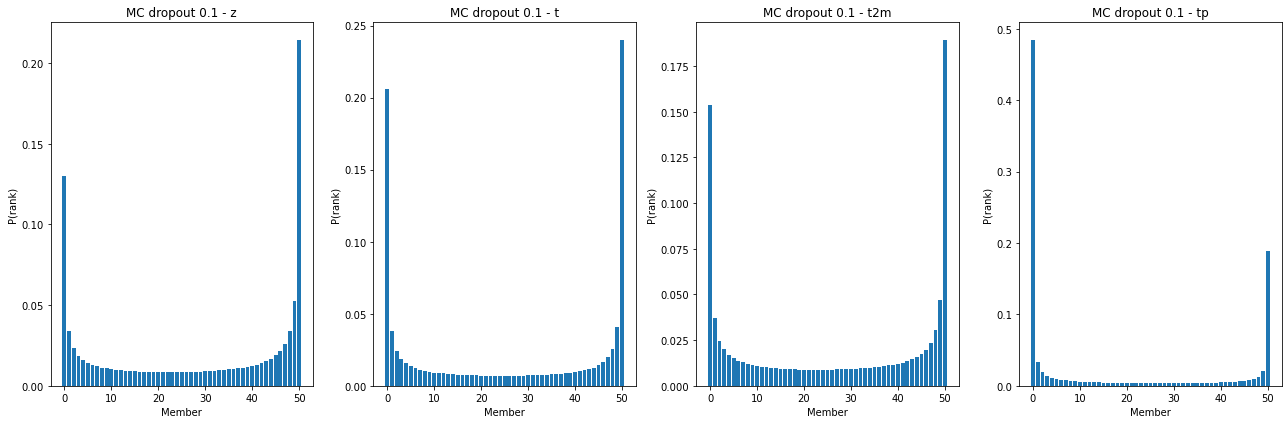

In [134]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6), sharey=False)
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[0.1][v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_xlabel('Member')
    axs[j].set_ylabel('P(rank)')
    axs[j].set_title(f'MC dropout 0.1 - {v}')
    #axs[j].gca().set_aspect('equal', adjustable='box')
fig.tight_layout()
plt.savefig(f'{result_dir}/figures/dr_rank.pdf')



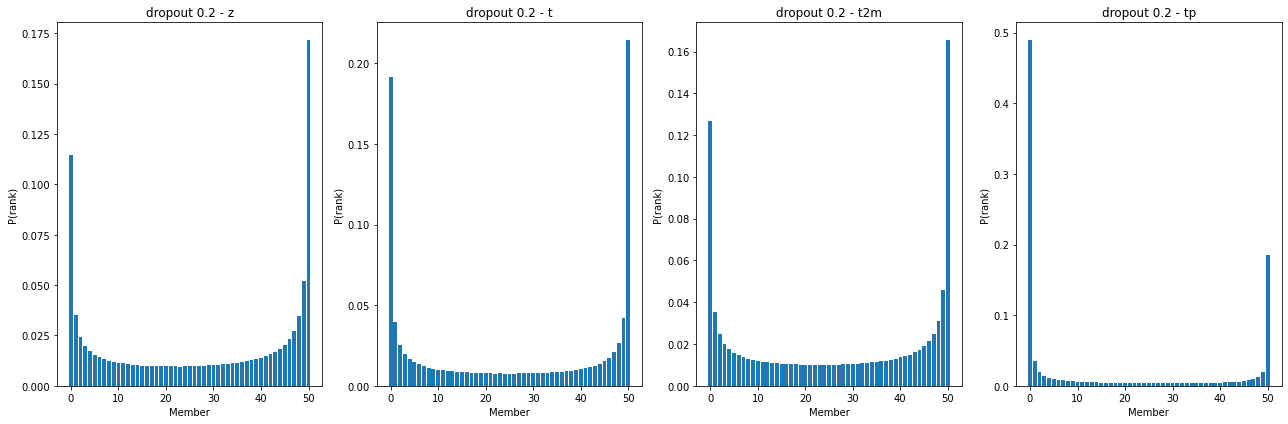

In [104]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6), sharey=False)
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[0.2][v]
    
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_xlabel('Member')
    axs[j].set_ylabel('P(rank)')
    
    axs[j].set_title(f'dropout 0.2 - {v}')
fig.tight_layout()

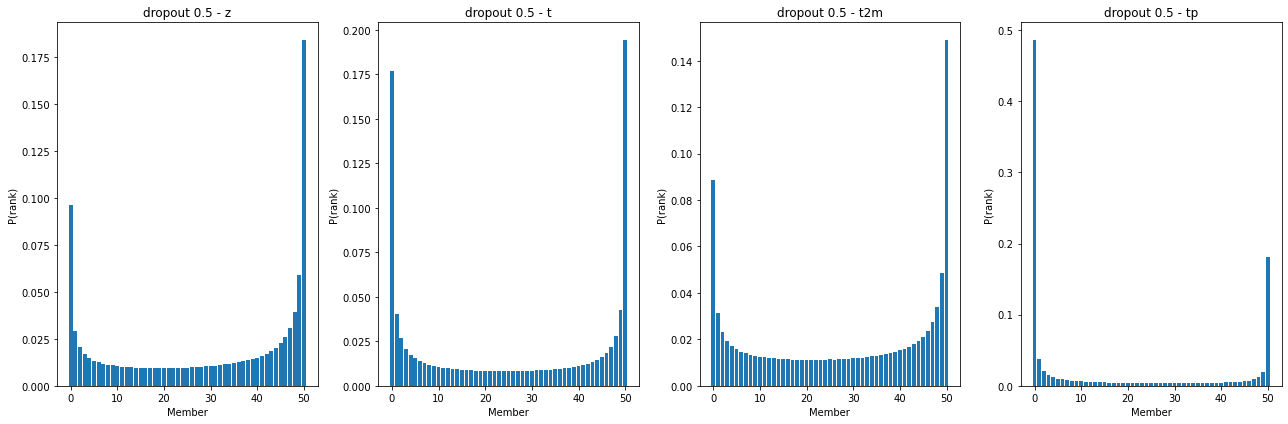

In [105]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6), sharey=False)
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[0.5][v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_xlabel('Member')
    axs[j].set_ylabel('P(rank)')
    
    axs[j].set_title(f'dropout 0.5 - {v}')
fig.tight_layout()

In [135]:
with open(f'/home/garg/data/WeatherBench/tmp/categorical_ranks.pkl', 'rb') as f:
    ranks= pickle.load(f)

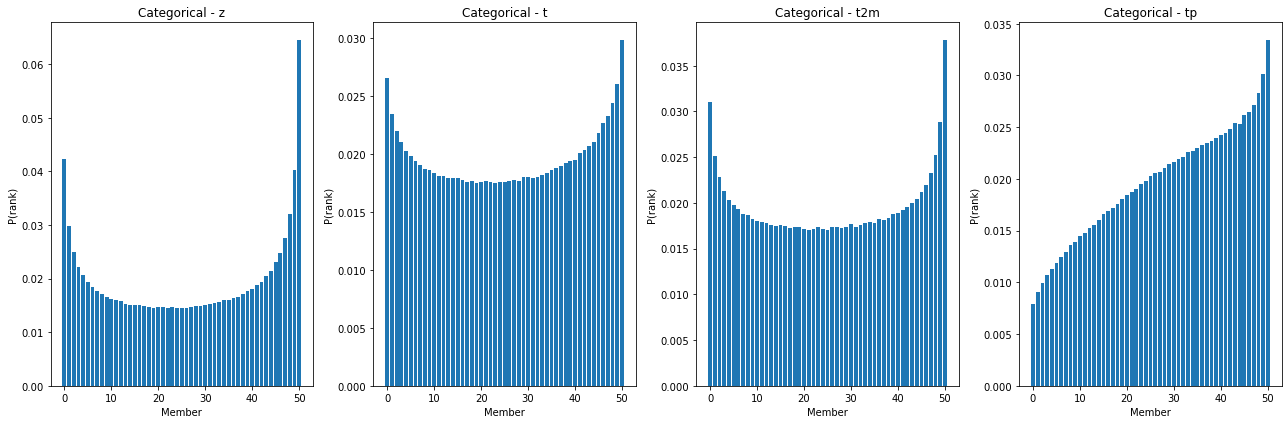

In [136]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6), sharey=False)
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_xlabel('Member')
    axs[j].set_ylabel('P(rank)')
    
    axs[j].set_title(f'Categorical - {v}')
fig.tight_layout()
plt.savefig(f'{result_dir}/figures/cat_rank.pdf')



In [108]:
#categorical tp better than z,t,t2m?

In [137]:
with open(f'/home/garg/data/WeatherBench/tmp/parametric_ranks.pkl', 'rb') as f:
    ranks= pickle.load(f)

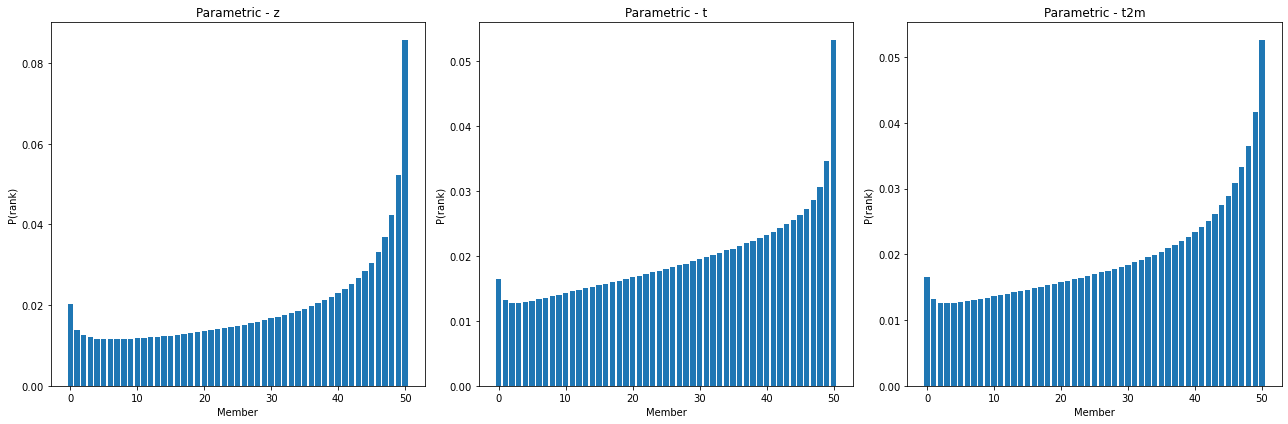

In [138]:
#Precipitation missing
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
for j, v in enumerate(['z', 't', 't2m']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_xlabel('Member')
    axs[j].set_ylabel('P(rank)')
    
    axs[j].set_title(f'Parametric - {v}')
    #axs[j].set_ylim(0,0.1)
fig.tight_layout()
plt.savefig(f'{result_dir}/figures/param_rank.pdf')



In [141]:
with open(f'/home/garg/data/WeatherBench/tmp/tigge_ranks.pkl', 'rb') as f:
    ranks= pickle.load(f)

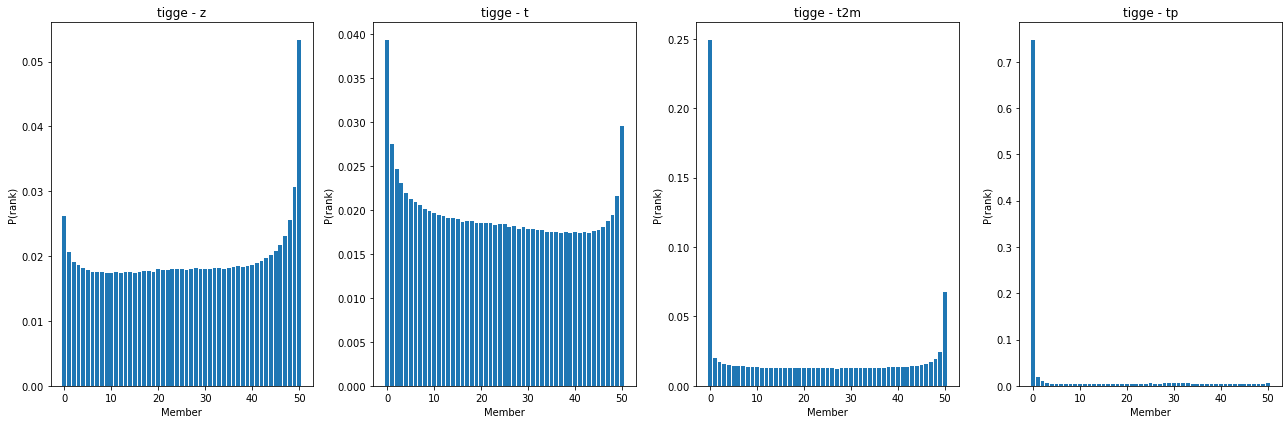

In [142]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6), sharey=False)
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_xlabel('Member')
    axs[j].set_ylabel('P(rank)')
    
    axs[j].set_title(f'tigge - {v}')
    #axs[j].set_ylim(0,.5)
fig.tight_layout()
plt.savefig(f'{result_dir}/figures/tigge_rank.pdf')



In [113]:
#Note: Categorical has been trained separetely for z, t, t2m, tp. 
#So has ~3 times more parameters than parametric, 
#still comparable performance b/w the two.


In [114]:
#right bias (underforecasting): my guess is it is predicting zeroes mostly for precipitation
#but what about others


#bias-global evaluations. (may need to consider tropics separetly)

# Global Maps